In [26]:
import pandas as pd
import numpy as np
import joblib 
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import  make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [27]:
def read_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    X_train = data["X_train"].copy()
    X_valid = data["X_valid"].copy()
    X_test = data["X_test"].copy()
    y_train = data["y_train"].copy()
    y_valid = data["y_valid"].copy()
    y_test = data["y_test"].copy()
    features = data['feature_selection'].copy()
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, features

In [28]:
data_path = 'Preprocessing/Final_data.pkl'
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

In [29]:
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)

In [43]:
random_seed = 42

from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=random_seed, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = ada.fit_resample(X, y)

Huấn luyện lại 3 mô hình *Random Forest*, *XGBoost* và *LightGBM*

Ở đây ta không quan tâm đến bước fine-tune và evaluation mà chỉ quan tâm đến ***mức đóng góp*** của từng feature cho mỗi mô hình

In [44]:
mean, std, all_scores = [], [], []

models = {
            'RFC': RandomForestClassifier(random_state=random_seed),
            'XGB': XGBClassifier(random_state=random_seed),
            'LGBM': LGBMClassifier(random_state=random_seed)
        }

for model_name, model in models.items():
    print(model_name)
    
    pl = Pipeline(
        steps=[
            ('classifier', model)
        ]
    )
    metric = make_scorer(roc_auc_score)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    scores = cross_val_score(pl, X, y, scoring=metric, cv=cv)
    print('-' * 30)

    model.fit(X_train, y_train)
    
    all_scores.append(scores)
    mean.append(np.mean(scores))
    std.append(np.std(scores))

RFC
------------------------------
XGB
------------------------------
LGBM
[LightGBM] [Info] Number of positive: 192, number of negative: 998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161345 -> initscore=-1.648258
[LightGBM] [Info] Start training from score -1.648258
[LightGBM] [Info] Number of positive: 192, number of negative: 998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161345 -> initscore=-1.648258
[

In [45]:
scores_df = pd.DataFrame()
scores_df['Mean (Accuracy Score)'] = mean
scores_df['Std'] = std
scores_df.index = models.keys()
scores_df

,Mean (Accuracy Score),Std
RFC,0.586068,0.044894
XGB,0.647772,0.051892
LGBM,0.645673,0.059259


In [56]:
# Get all features
all_features = features.index.tolist()
importance_df = pd.DataFrame()
importance_rank_df = pd.DataFrame()

### 1. Random Forest

In [57]:
forest = models['RFC']
forest_importances = forest.feature_importances_.tolist()
importance_df['Random Forest'] = forest_importances
ranks = np.argsort(-np.array(forest_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['Random Forest'] = ranks

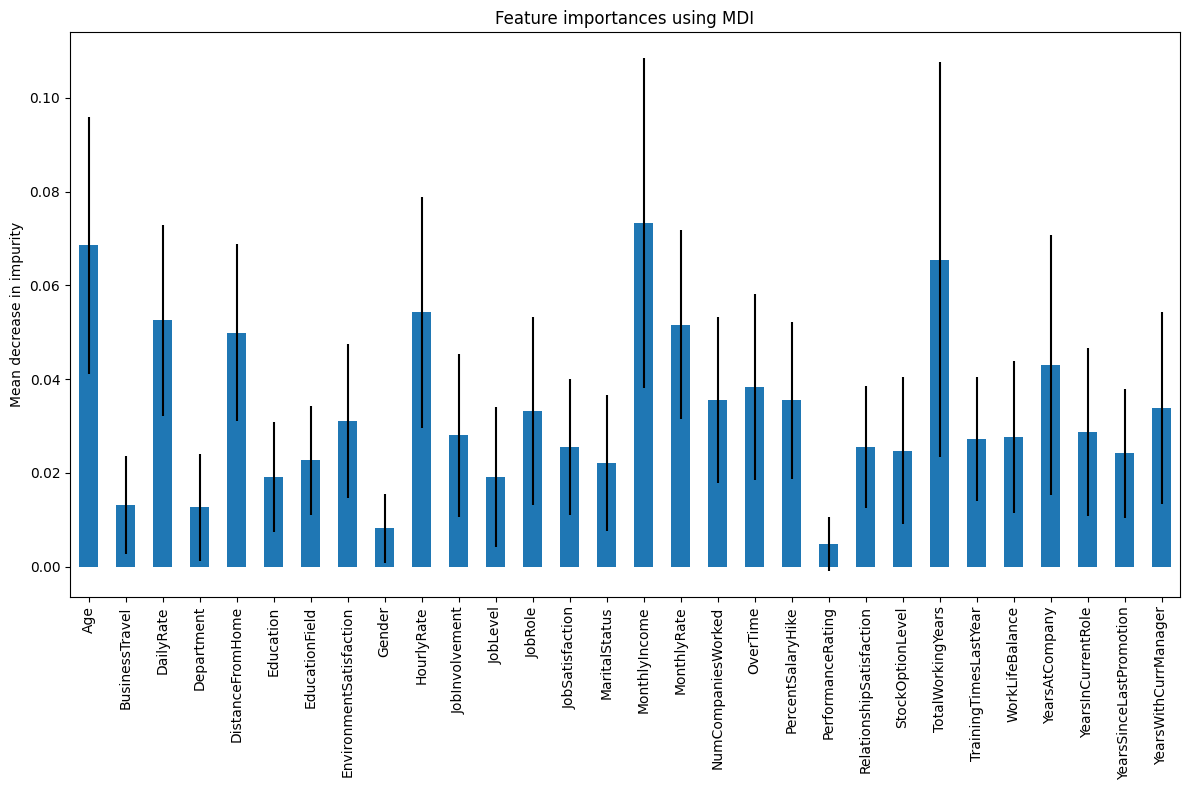

In [58]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_plot = pd.Series(forest_importances, index=all_features)

plt.figure(figsize=(12,8))
forest_plot.plot.bar(yerr=std)
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()

### 2. XGBoost

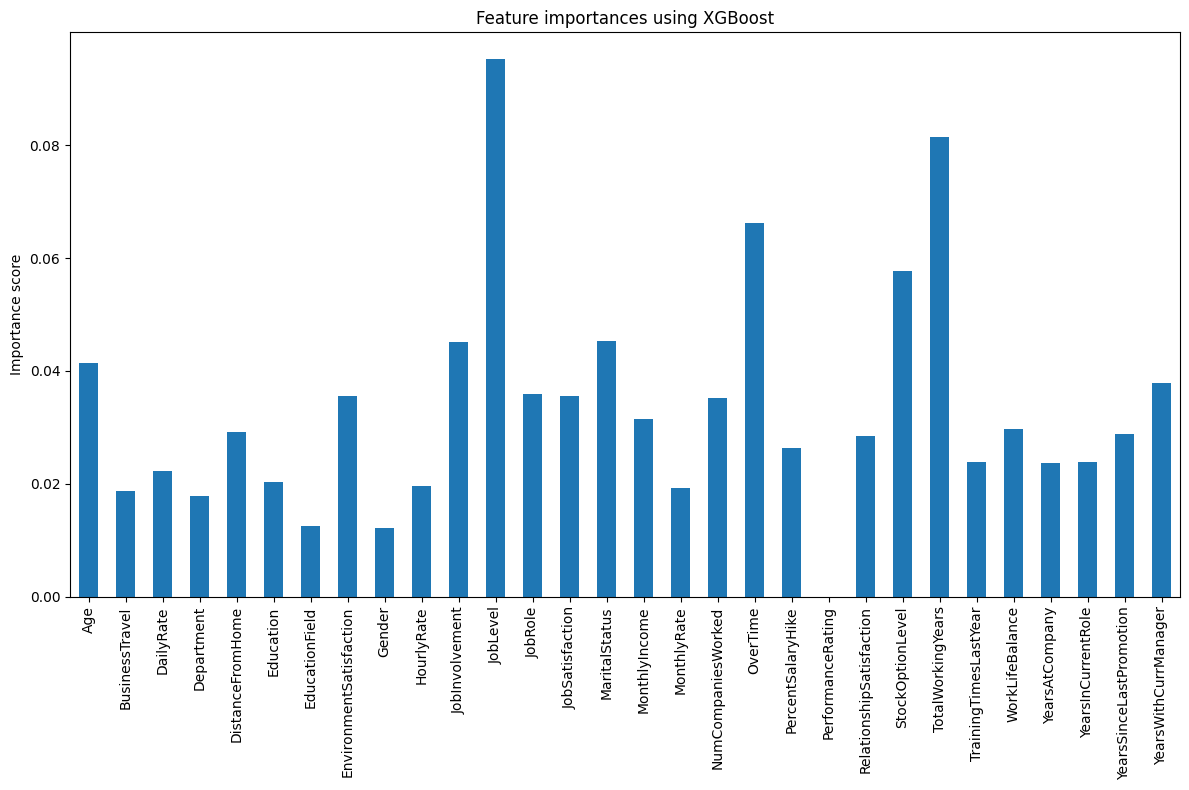

In [59]:
xgb_model = models['XGB']
xgb_importances = xgb_model.feature_importances_
importance_df['XGBoost'] = xgb_importances
ranks = np.argsort(-np.array(xgb_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['XGBoost'] = ranks

xgb_plot = pd.Series(xgb_importances, index=all_features)

plt.figure(figsize=(12,8))
xgb_plot.plot.bar()
plt.title("Feature importances using XGBoost")
plt.ylabel("Importance score")
plt.tight_layout()

### 3. LightGBM

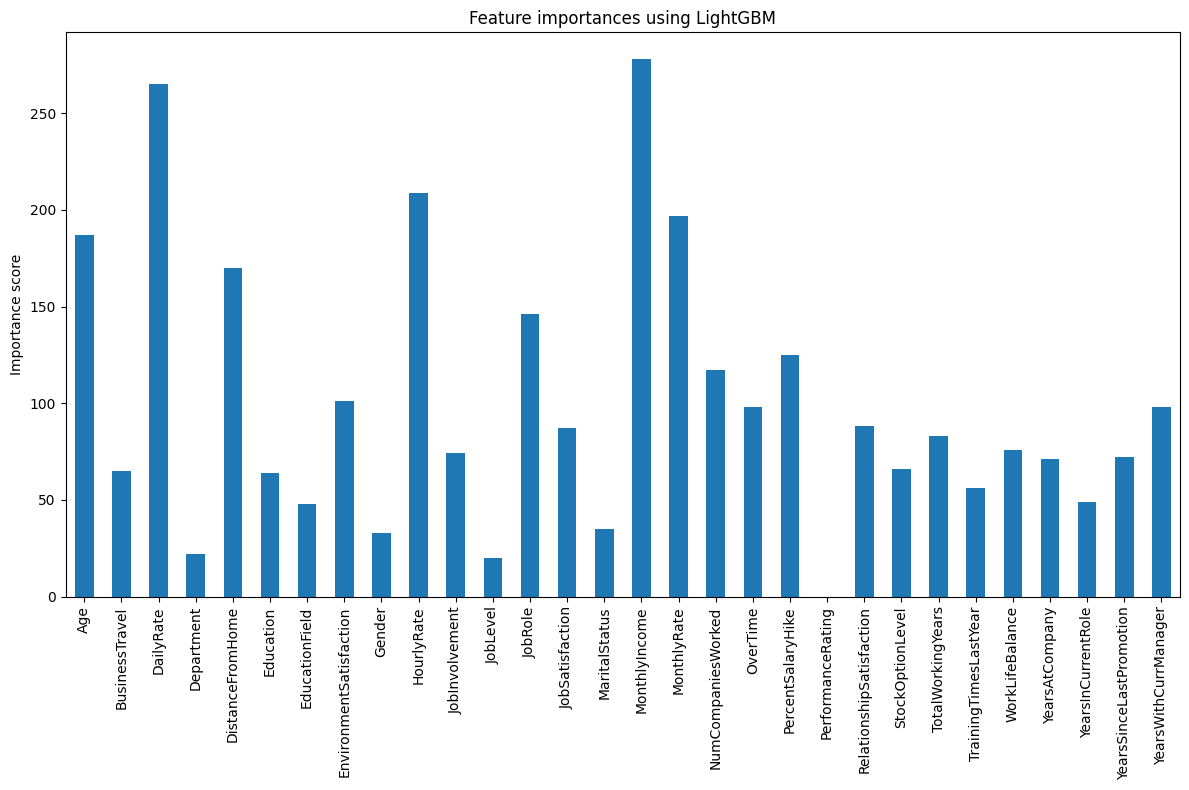

In [60]:
lgbm_model = models['LGBM']
lgbm_importances = lgbm_model.feature_importances_
importance_df['LightGBM'] = lgbm_importances
ranks = np.argsort(-np.array(lgbm_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['LightGBM'] = ranks

lgbm_plot = pd.Series(lgbm_importances, index=all_features)

plt.figure(figsize=(12,8))
lgbm_plot.plot.bar()
plt.title("Feature importances using LightGBM")
plt.ylabel("Importance score")
plt.tight_layout()

### 4. CatBoost

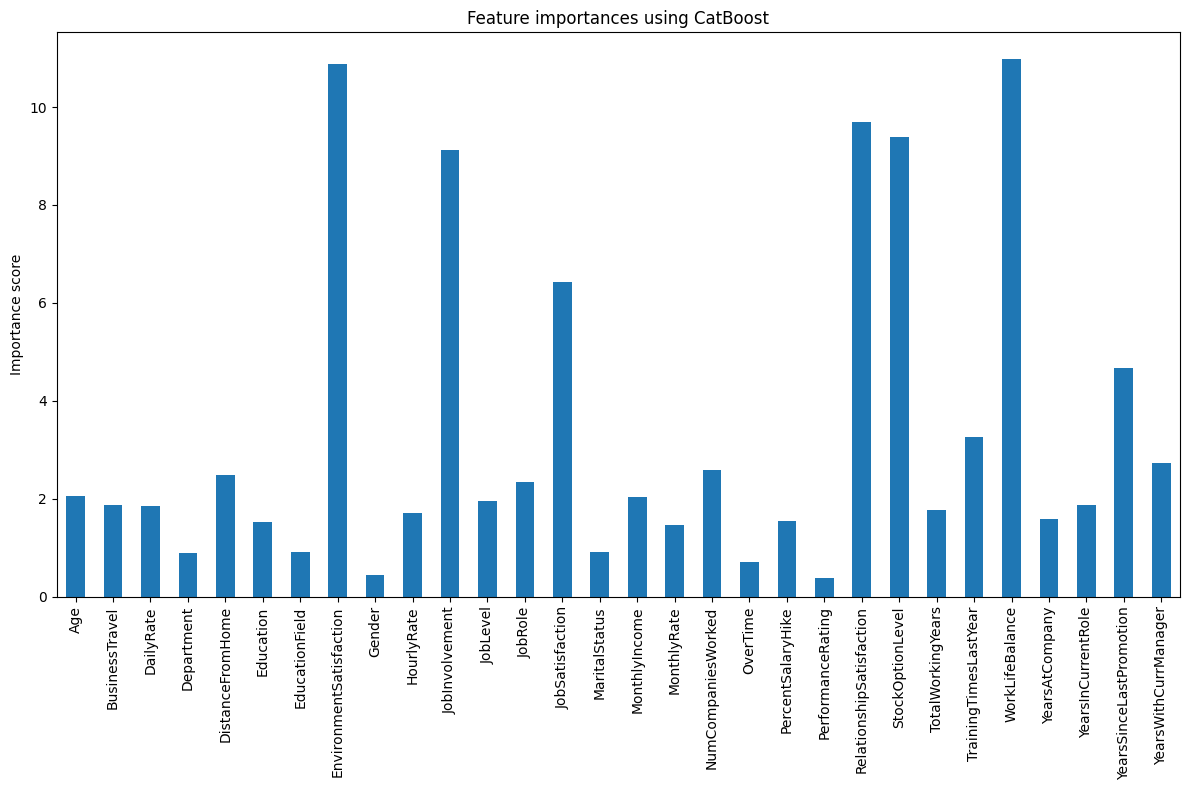

In [61]:
catboost_model = CatBoostClassifier().load_model('Models/CatBoost/catboost_model__30_features__roc_auc_objective__1744091693.cbm')
catboost_importances = catboost_model.get_feature_importance().tolist()
importance_df['CatBoost'] = catboost_importances
ranks = np.argsort(-np.array(catboost_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['CatBoost'] = ranks

catboost_plot = pd.Series(catboost_importances, index=all_features)

plt.figure(figsize=(12,8))
catboost_plot.plot.bar()
plt.title("Feature importances using CatBoost")
plt.ylabel("Importance score")
plt.tight_layout()


### 4. Logistic Regression

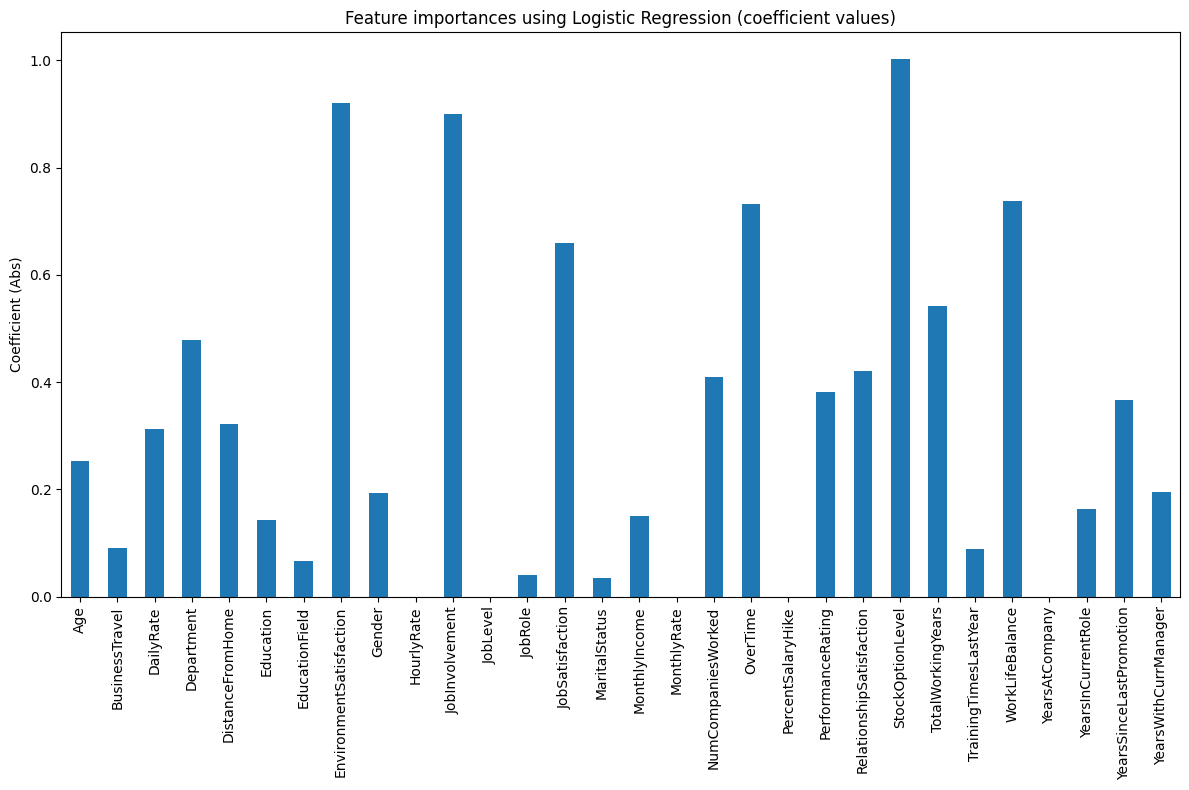

In [62]:
lr = joblib.load('Models/LogisticRegression/lr_model__30_features__roc_auc_objective__1744344039.lr')

lr_importances = np.abs(lr.coef_[0])

importance_df['LogisticRegression'] = lr_importances

lr_ranks = np.argsort(-lr_importances)
lr_ranks = np.argsort(lr_ranks) + 1
importance_rank_df['LogisticRegression'] = lr_ranks

lr_plot = pd.Series(lr_importances, index=all_features)

plt.figure(figsize=(12, 8))
lr_plot.plot.bar()
plt.title("Feature importances using Logistic Regression (coefficient values)")
plt.ylabel("Coefficient (Abs)")
plt.tight_layout()
plt.show()

### 5. Comparisions

In [63]:
importance_df.index = all_features
importance_df.sort_values('LogisticRegression', ascending=0)

,Random Forest,XGBoost,LightGBM,CatBoost,LogisticRegression
StockOptionLevel,0.024770,0.057634,66,9.396630,1.002186
EnvironmentSatisfaction,0.031069,0.035533,101,10.881763,0.920651
JobInvolvement,0.028026,0.045189,74,9.115569,0.899511
WorkLifeBalance,0.027653,0.029622,76,10.977408,0.738409
OverTime,0.038350,0.066224,98,0.706559,0.732523
JobSatisfaction,0.025494,0.035458,87,6.416498,0.659163
TotalWorkingYears,0.065480,0.081390,83,1.773799,0.541931
Department,0.012640,0.017898,22,0.887880,0.478856
RelationshipSatisfaction,0.025546,0.028464,88,9.703440,0.421152
NumCompaniesWorked,0.035546,0.035230,117,2.580460,0.408744


In [64]:
importance_df.index = all_features
importance_df.sort_values('CatBoost', ascending=0)

,Random Forest,XGBoost,LightGBM,CatBoost,LogisticRegression
WorkLifeBalance,0.027653,0.029622,76,10.977408,0.738409
EnvironmentSatisfaction,0.031069,0.035533,101,10.881763,0.920651
RelationshipSatisfaction,0.025546,0.028464,88,9.703440,0.421152
StockOptionLevel,0.024770,0.057634,66,9.396630,1.002186
JobInvolvement,0.028026,0.045189,74,9.115569,0.899511
JobSatisfaction,0.025494,0.035458,87,6.416498,0.659163
YearsSinceLastPromotion,0.024213,0.028736,72,4.663651,0.367226
TrainingTimesLastYear,0.027248,0.023910,56,3.258878,0.089235
YearsWithCurrManager,0.033862,0.037781,98,2.727343,0.194842
NumCompaniesWorked,0.035546,0.035230,117,2.580460,0.408744


In [65]:
importance_rank_df.index = all_features
importance_rank_df['Average Rank'] = importance_rank_df.mean(axis=1)
importance_rank_df.sort_values('Average Rank', ascending=1)

,Random Forest,XGBoost,LightGBM,CatBoost,LogisticRegression,Average Rank
EnvironmentSatisfaction,14,10,10,2,2,7.6
Age,2,7,5,13,15,8.4
TotalWorkingYears,3,2,15,19,7,9.2
JobInvolvement,16,6,17,5,3,9.4
MonthlyIncome,1,13,1,14,19,9.6
StockOptionLevel,21,4,20,4,1,10.0
NumCompaniesWorked,10,12,9,10,10,10.2
WorkLifeBalance,17,14,16,1,4,10.4
DistanceFromHome,7,15,6,11,13,10.4
OverTime,9,3,11,28,5,11.2


### 6. Conclusions

Từ những mức đóng góp của các đặc trưng cho từng mô hình, ta có một số nhận xét như sau:

* **MonthlyIncome**, **Age**, **TotalWorkingYears** và **EnvironmentSatisfaction** là những đặc trưng có ảnh hưởng nhiều nhất đến xu hướng nghỉ việc của nhân viên

* **Education**, **EducationField**, **Department**, **Gender** và **PerformanceRating** là đặc trưng ít quan trọng nhất của cả 5 mô hình. Điều này cho thấy những yếu tố này không có nhiều tác động đến sự nghỉ việc hay rời bỏ công ty của nhân viên